### [1.00]: Import the required modules.

In [1]:
# Import the required modules.
import os
import re
import wx  # Install it with pip.
import sys
import json
import shutil
import numpy as np
import pandas as pd
from os import path
from datetime import datetime

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

### [1.10]: Instantiate the ML pipeline class.

#### [1.11]: Prompt for file upload.

In [2]:
# Function to prompt the user to upload the file.
def get_path(wildcard):
    app = wx.App(None)
    style = wx.FD_OPEN | wx.FD_FILE_MUST_EXIST
    dialog = wx.FileDialog(None, 'Choose a training file.', wildcard=wildcard, style=style)
    if dialog.ShowModal() == wx.ID_OK:
        path = dialog.GetPath()
    else:
        path = None
    dialog.Destroy()
    return path

#### [1.12] : Instantiate the ML Pipleline class

In [3]:
try:
    # Call the funtion to get the input files.
    #s_infile = get_path('*.csv')
    s_infile = get_path('*.xlsx')
    s_infile = s_infile.replace("\\","\\\\")

    # Get the current working directory.
    s_path = os.getcwd()
    s_path = s_path.replace("\\","\\\\")
    s_basefile = os.path.basename(s_infile)
    s_basefile_csv = (os.path.splitext(s_basefile)[0]) + '.csv'

    # Check, if path exists in system path,else add.
    if s_path in os.environ:
        sys.path.append(s_path)

    # Instantiate and Consume the class.
    from classMLModelingPipeline import *
    # Open and read the App Configuration using json.
    with open(s_path + '\\AppConfig.txt') as json_file:
        # Load the App config details.
        data = json.load(json_file)
        # For each entry in json, extract App config parameters.
        for p in data['AppConfig']:
            applConfig = modMLModelingPipeline  (  p['Id'],
                                                    p['Name'],
                                                    p['Source'],
                                                    p['Output'],
                                                    p['TrainedModel'],
                                                    p['ExecutionLog'],
                                                    p['ExecutionLogFileName'],
                                                    p['Archive']
                                                  )
    #===== Create Application Directories ============================================================
    s_classApplication  = 'classMLModelingPipeline'
    s_classMethod       = 'CreateAppDirectories'
    s_statusType        = 'Success'
    s_statusDescription = 'Successfull write operation.'
    applConfig.CreateAppDirectories()
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )
except AttributeError:
    s_statusDescription = 'No file has been choosen!!!!' 
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)
except:
    s_statusDescription = 'Unexpected error : ' 
    s_statusDescription = s_statusDescription + str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)

### [1.20]: Data loading

In [4]:
try:
    s_classMethod       = 'Data Loading'    
    s_statusType        = 'Success'
    # Read the input file, sheet considered is "Final Sheet"; skip firstrow.
    data_xls = pd.read_excel(s_infile, 'Final Sheet', index_col=None,skiprows=[0])
    # Drop empty rows.
    data_xls.dropna(axis=0,how='any',inplace=True)
    # Get the path to source directory from class.
    s_in_source_file = applConfig.Source
    s_in_source_file = s_in_source_file + s_basefile_csv

    # Convert it to .csv utf-8 format.
    data_xls.to_csv(s_in_source_file, encoding='utf-8')
    
    # Load the data from the csv file into pandas dataframe.
    dfDataVendor = pd.read_csv(s_in_source_file
                               ,parse_dates = ['Doc. Date','Del Date','GRN Date']
                               ,infer_datetime_format = True
                              )
except:
    s_statusType        = 'Error'    
    s_statusDescription = 'Unexpected error : ' 
    s_statusDescription = s_statusDescription + str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)    

In [5]:
try:
    s_classMethod       = 'Drop Unnamed Column'
    s_statusType        = 'Success'
    # Drop the unwanted column.
    dfDataVendor.drop(columns=['Unnamed: 0'],inplace=True)
except KeyError:
    pass
except:
    s_statusType        = 'Error'
    s_statusDescription = 'Unexpected error : ' 
    s_statusDescription = s_statusDescription + str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)

### [1.30]: Data pre-processing.

#### [1.31]: Extract VendorCode.

In [6]:
try:
    s_classMethod       = 'Extract Vendor Code'
    s_statusType        = 'Success'    
    # Extract VendorCode from "Supplier/Supplying Plant" column.
    dfDataVendor['VendorCode']  = dfDataVendor['Supplier/Supplying Plant'].str.extract('(\d+)')
    # Alternate way:
    #dfDataVendor['VendorCode']  = dfDataVendor['Supplier/Supplying Plant'].str.extract('([0-9][0-9][0-9][0-9][0-9][0-9]+)')
except:
    s_statusType        = 'Error'
    s_statusDescription = s_statusDescription + str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)

#### [1.32]: Inspect datatypes and perform validation.

In [14]:
def GetValidExceptionForDates(lstDateColumns, # list of date columns to validate.
                              dfData,          # data frame of the input data.
                              infile_skiprows  # number of rows to skip in the begining from the input file.
                             ):
    # Initialize.
    validationException = ''
    validException_item = ''
    # Corrected Row_index in source file.
    cRowIndex = infile_skiprows + 2
    # Build the Validation Exception message.
    validExceptionPresent = 0
    #validExcept_header = "'ValidationException':"
    validExcept_body   = "'Incorrect_DateFormat' : ["
    validExcept_bodyfooter = "]"
    # Loop through the list of Date columns.
    for itm in lstDateColumns:
        # Validate columns.
        dfDateCheck = pd.to_datetime(dfData[itm],errors='coerce')
        lstDateExceptions = list(dfDateCheck[dfDateCheck.isnull()].index+cRowIndex)
        if len(lstDateExceptions) > 0:
            validExceptionPresent = 1
            validException_item = validException_item + "'" + itm + "':" + str(lstDateExceptions) + ","

    if validExceptionPresent:
        # Remove extra comma.
        validException_item = validException_item[:-1]
        # Build the Validation Exception Message.
        validationException = validExcept_body + validException_item + validExcept_bodyfooter
    return validationException

In [15]:
def GetValidExceptionForNumeric(lstNumericColumns,  # list of date columns to validate.
                                dfData,          # data frame of the input data.
                                infile_skiprows  # number of rows to skip in the begining from the input file.
                               ):
    # Initialize.
    validationException = ''
    validException_item = ''
    # Corrected Row_index in source file.
    cRowIndex = infile_skiprows + 2
    # Build the Validation Exception message.
    validExceptionPresent = 0
    #validExcept_header = "'ValidationException':"
    validExcept_body   = "'Incorrect_NumericFormat' : ["
    validExcept_bodyfooter = "]"
    # Loop through the list of Date columns.
    for itm in lstNumericColumns:
        # Validate columns.
        dfNumericCheck = pd.to_numeric(dfData[itm],errors='coerce')
        lstNumericExceptions = list(dfNumericCheck[dfNumericCheck.isnull()].index+cRowIndex)
        if len(lstNumericExceptions) > 0:
            validExceptionPresent = 1
            validException_item = validException_item + "'" + itm + "':" + str(lstNumericExceptions) + ","

    if validExceptionPresent:
        # Remove extra comma.
        validException_item = validException_item[:-1]
        # Build the Validation Exception Message.
        validationException = validExcept_body + validException_item + validExcept_bodyfooter
    return validationException

In [16]:
try:
    # Consolidate error description to write to log.
    #======= Validate Numeric columns ========================================================================================
    raise_Except = 0
    validationException = ''
    strComma = ''
    validExcept_header = "'ValidationException':"
    s_statusType        = 'ValidationException'    
    s_classMethod       = 'Parse Datatypes'
    # Convert date column's datatype from string to datetime.
    lstNumericCols = ['Sum of PO Quantity','Sum of      Net Price','Sum of PO Value', 'Sum of GRN Qty','Sum of GRN Val']
    exceptMessage = GetValidExceptionForNumeric(lstNumericColumns = lstNumericCols, # list of numeric columns to validate.
                                              dfData = dfDataVendor, # data frame of the input data.
                                              infile_skiprows = 1    # number of rows to skip in the begining from the input file.
                                             )
    if len(exceptMessage) > 0:
        raise_Except = 1
        s_statusDescription = exceptMessage

    #======= Validate Numeric columns =====================================================================================
    # set the class name and status.
    # Convert date column's datatype from string to datetime.
    lstDateCols = ['Doc. Date','Del Date','GRN Date']
    # Get the validation exceptions.
    exceptMessage = GetValidExceptionForDates(lstDateColumns = lstDateCols, # list of date columns to validate.
                                              dfData = dfDataVendor, # data frame of the input data.
                                              infile_skiprows = 1    # number of rows to skip in the begining from the input file.
                                             )
    # If validation exception found.
    if len(exceptMessage) > 0:
        if raise_Except == 1:
            strComma = ','
        raise_Except = 1
        s_statusDescription = s_statusDescription + strComma + exceptMessage
    
    if raise_Except:
        validationException = validExcept_header + '{' + s_statusDescription + '}'
        # Write to log.
        applConfig.WriteToActivityLog(s_classApplication,
                                      s_classMethod,
                                      s_statusType,
                                      s_statusDescription
                                     ) 
        
        raise Exception('Data validation error/s occured. Please check the application log.')
        
except:
    s_statusType        = 'Error'
    s_statusDescription = validationException + str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)    

Exception: 'ValidationException':{'Incorrect_NumericFormat' : ['Sum of      Net Price':[95, 96],'Sum of GRN Val':[95, 96]],'Incorrect_DateFormat' : ['GRN Date':[97]]}(<class 'Exception'>, Exception('Data validation error occured. Please check the application logs.'), <traceback object at 0x000001455C434088>)

In [ ]:
'''
try:
    s_classMethod       = 'Parse Numeric Datatypes'
    s_statusType        = 'ValidationException'    
    # Convert date column's datatype from string to datetime.
    lstNumericCols = ['Sum of PO Quantity','Sum of      Net Price','Sum of PO Value', 'Sum of GRN Qty','Sum of GRN Val']
    exceptMessage = GetValidExceptionForNumeric(lstNumericColumns = lstNumericCols, # list of numeric columns to validate.
                                              dfData = dfDataVendor, # data frame of the input data.
                                              infile_skiprows = 1    # number of rows to skip in the begining from the input file.
                                             )
    s_statusDescription = exceptMessage
    if len(s_statusDescription) > 0:
        applConfig.WriteToActivityLog(s_classApplication,
                                      s_classMethod,
                                      s_statusType,
                                      s_statusDescription
                                     ) 
        raise Exception(s_statusDescription)
except:
    s_statusType        = 'Error'
    s_statusDescription = s_statusDescription + str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)
'''    

In [11]:
'''
try:
    # set the class name and status.
    s_classMethod       = 'Parse Date Datatypes'
    s_statusType        = 'ValidationException'    
    # Convert date column's datatype from string to datetime.
    lstDateCols = ['Doc. Date','Del Date','GRN Date']
    # Get the validation exceptions.
    exceptMessage = GetValidExceptionForDates(lstDateColumns = lstDateCols, # list of date columns to validate.
                                              dfData = dfDataVendor, # data frame of the input data.
                                              infile_skiprows = 1    # number of rows to skip in the begining from the input file.
                                             )
    s_statusDescription = exceptMessage
    # If validation exception found.
    if len(s_statusDescription) > 0:
        # Write to log.
        applConfig.WriteToActivityLog(s_classApplication,
                                      s_classMethod,
                                      s_statusType,
                                      s_statusDescription
                                     ) 
        # Raise the exception.
        raise Exception(s_statusDescription)    
except:
    # set the status type, description and write to log.
    s_statusType        = 'Error'
    s_statusDescription = s_statusDescription + str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)
'''    

Exception: 'ValidationException':{'Incorrect_DateFormat' : ['GRN Date':[97]]}(<class 'Exception'>, Exception("'ValidationException':{'Incorrect_DateFormat' : ['GRN Date':[97]]}"), <traceback object at 0x00000242FC597388>)

#### [1.33]: Export data cleansed, so far to .csv format for inspection.

In [38]:
# Export the date columns to a csv file and manually inspect for anamolies.
dfDataVendor[['GRN Date','Doc. Date','Del Date','VendorCode']].to_csv('Data_Inspect.csv')

#### [1.34]: Get the latest data for multiple vendor occurence for the given snapshot.

In [39]:
try:
    s_classMethod       = 'Resolve Multiple Material-Vendor combo'
    s_statusType        = 'Success'    
    # Get the latest data for material/combo appearing more than once.
    dfDataVendorMaxDate = dfDataVendor.groupby(['Material', \
                                                'UOM', \
                                                'VendorCode']).agg({'Doc. Date':'max', \
                                                                    'Del Date' : 'max', \
                                                                    'GRN Date' : 'max', \
                                                                    'Sum of PO Quantity':'mean', \
                                                                    'Sum of      Net Price':'mean', \
                                                                    'Sum of PO Value' : 'mean', \
                                                                    'Sum of GRN Qty' : 'mean', \
                                                                    'Sum of GRN Val' : 'mean'
                                                                    }) \
                          .reindex(['Doc. Date','Del Date', \
                                    'GRN Date','Sum of PO Quantity', \
                                    'Sum of      Net Price', \
                                    'Sum of PO Value', \
                                    'Sum of GRN Qty', \
                                    'Sum of GRN Val'
                                   ], axis=1) \
                          .reset_index()
except:
    s_statusType        = 'Error'
    s_statusDescription = s_statusDescription + str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)

#### [1.35]: Calculate the deviation metrics.

In [40]:
try:
    s_classMethod       = 'Calculate deviation metrics'
    s_statusType        = 'Success'    
    # Deviation in expected vs actual delivery dates.
    dfDataVendorMaxDate['Deviation_DeliveryDate'] = (dfDataVendorMaxDate['GRN Date'] - dfDataVendorMaxDate['Del Date']).dt.days

    # Deviation in expected vs actual delivered quantity.
    dfDataVendorMaxDate['Deviation_DeliveredQty'] = (dfDataVendorMaxDate['Sum of PO Quantity'] - dfDataVendorMaxDate['Sum of GRN Qty']) \
    /dfDataVendorMaxDate['Sum of PO Quantity']

    # Round of to the nearest 3rd decimal.
    dfDataVendorMaxDate['Deviation_DeliveredQty'] = dfDataVendorMaxDate['Deviation_DeliveredQty'].round(3)

    # Deviation in expected vs actual delivered value.
    dfDataVendorMaxDate['Deviation_DeliveredValue'] = (dfDataVendorMaxDate['Sum of PO Value'] - dfDataVendorMaxDate['Sum of GRN Val']) \
    /dfDataVendorMaxDate['Sum of PO Value']

    # Round of to the nearest 3rd decimal.
    dfDataVendorMaxDate['Deviation_DeliveredValue'] = dfDataVendorMaxDate['Deviation_DeliveredValue'].round(3)

    # Handle negative deviations in quantity and value. Delivered more qty/value than the PO contract.
    dfDataVendorMaxDate.loc[dfDataVendorMaxDate['Deviation_DeliveredQty']   < 0.0,  'Deviation_DeliveredQty'] = 0.0
    dfDataVendorMaxDate.loc[dfDataVendorMaxDate['Deviation_DeliveredValue'] < 0.0,'Deviation_DeliveredValue'] = 0.0

    # Assign the finalized data.
    dfDataVendorLatest = dfDataVendorMaxDate
except:
    s_statusType        = 'Error'
    s_statusDescription = s_statusDescription + str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)    

### [1.40]: Build the final dataframe for ML modelling.

#### [1.41]: Concatenate all the required columns.

In [41]:
try:
    s_classMethod       = 'Finalize the columns in dataframe.'
    s_statusType        = 'Success'    
    # Concat all the columns required for the analysis.
    dfDataVendorFinal = dfDataVendorLatest[['Doc. Date','VendorCode','Material','Deviation_DeliveryDate', \
                                     'Deviation_DeliveredQty','Deviation_DeliveredValue']].copy()
except:
    s_statusType        = 'Error'
    s_statusDescription = s_statusDescription + str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)     

#### [1.42]: Explore the distribution of data.

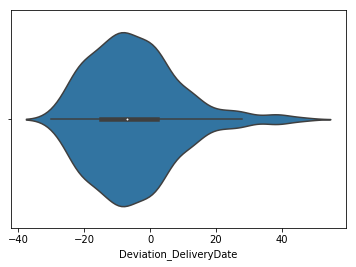

In [42]:
# For variable : "Deviation_DeliveryDate"
# Import the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Create violinplot
sns.violinplot(x = "Deviation_DeliveryDate", data=dfDataVendorFinal)

# Show the plot
plt.show()

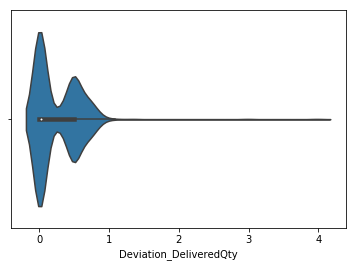

In [43]:
# For variable : "Deviation_DeliveredQty"
# Import the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Create violinplot
sns.violinplot(x = "Deviation_DeliveredQty", data=dfDataVendorFinal)

# Show the plot
plt.show()

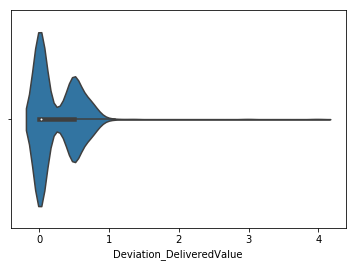

In [44]:
# For variable : "Deviation_DeliveredValue"
# Import the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Create violinplot
sns.violinplot(x = "Deviation_DeliveredValue", data=dfDataVendorFinal)

# Show the plot
plt.show()

#### [1.43]: Generate the class label.

In [45]:
# Function to generate the class Label.
def getClassDelivery(dfClassDelivery):
    # Store the actual index.
    dfIndex = dfClassDelivery.index
    # Set the index to 'Material'to partition the dataset.
    dfClassDelivery.set_index('Material', inplace=True)
    # Loop through the distinct partition value.
    for i in (set(dfClassDelivery.index)):
        # Apply partition, on the 'Material' column.
        slicer = (dfClassDelivery.index.values == i)
        # Vendor delivers, 30 days earlier or more, than the contract delivery date.
        # No deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                              (dfClassDelivery['Deviation_DeliveryDate']   < -30.0) & \
                              (dfClassDelivery['Deviation_DeliveredQty']   == 0.0) 
                            ),  \
                             'classDelivery'] = 1
    
        # 25% deviation in quantity delivered.
        dfClassDelivery.loc[(
                                (slicer) & \
                                (dfClassDelivery['Deviation_DeliveryDate']   < -30.0) & \
                                ( (dfClassDelivery['Deviation_DeliveredQty']   > 0.0)   & \
                                  (dfClassDelivery['Deviation_DeliveredQty']   <= 0.25))
                             ),'classDelivery'] = 2

        # 25% to 50% deviation in quantity delivered.
        dfClassDelivery.loc[(
                                (slicer) & \
                                (dfClassDelivery['Deviation_DeliveryDate']   < -30.0) & \
                                ((dfClassDelivery['Deviation_DeliveredQty']   > 0.25)   & \
                                (dfClassDelivery['Deviation_DeliveredQty']   <= 0.50))
                            ),'classDelivery'] = 3

        # 50% to 75% deviation in quantity delivered.
        dfClassDelivery.loc[(   (slicer) & \
                                (dfClassDelivery['Deviation_DeliveryDate']   < -30.0) & \
                                ( (dfClassDelivery['Deviation_DeliveredQty']   > 0.50)   & \
                                  (dfClassDelivery['Deviation_DeliveredQty']   <= 0.75))
                             ),'classDelivery'] = 4
    
        # More than 75% deviation in quantity delivered.
        dfClassDelivery.loc[(   (slicer) & \
                                (dfClassDelivery['Deviation_DeliveryDate']   < -30.0) & \
                                ((dfClassDelivery['Deviation_DeliveredQty']  > 0.75))
                             ),'classDelivery'] = 5
    

        # Vendor delivers, 15-30 days earlier,  than the contract date.
        # No deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   >= -30.0) & \
                            (dfClassDelivery['Deviation_DeliveryDate']   <= -15.0)) & \
                            (dfClassDelivery['Deviation_DeliveredQty']   == 0.0) 
                        ),'classDelivery'] = 6
    
        # 25% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   >= -30.0) & \
                            (dfClassDelivery['Deviation_DeliveryDate']   <= -15.0)) & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.0)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']   <= 0.25)) 
                        ),'classDelivery'] = 7

        # 25% to 50% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   >= -30.0) & \
                            (dfClassDelivery['Deviation_DeliveryDate']   <= -15.0)) & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.25)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']   <= 0.50)) 
                        ),'classDelivery'] = 8

        # 50% to 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   >= -30.0) & \
                            (dfClassDelivery['Deviation_DeliveryDate']   <= -15.0)) & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.50)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']   <= 0.75)) 
                        ),'classDelivery'] = 9
    
        # More than 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   >= -30.0) & \
                            (dfClassDelivery['Deviation_DeliveryDate']   <= -15.0)) & \
                            (dfClassDelivery['Deviation_DeliveredQty']   > 0.75) 
                        ),'classDelivery'] = 10

        # Vendor delivers, 1-14 days earlier,  than the contract date.  
        # No deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   > -15.0) & \
                             (dfClassDelivery['Deviation_DeliveryDate']   < 0.0))  & \
                            (dfClassDelivery['Deviation_DeliveredQty']   == 0.0) 
                        ),'classDelivery'] = 11
    
        # 25% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   > -15.0) & \
                             (dfClassDelivery['Deviation_DeliveryDate']   < 0.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.00)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.25)) 
                        ),'classDelivery'] = 12

        # 25% to 50% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   > -15.0) & \
                             (dfClassDelivery['Deviation_DeliveryDate']   < 0.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.25)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.50)) 
                        ),'classDelivery'] = 13

        # 50% to 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   > -15.0) & \
                             (dfClassDelivery['Deviation_DeliveryDate']   < 0.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.50)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.75)) 
                        ),'classDelivery'] = 14
    
        # More than 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   > -15.0) & \
                             (dfClassDelivery['Deviation_DeliveryDate']   < 0.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.75)) 
                        ),'classDelivery'] = 15

        # Vendor delivers on expected date as per the contract.
        # No deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                             ((dfClassDelivery['Deviation_DeliveryDate']   == 0.0))  & \
                             (dfClassDelivery['Deviation_DeliveredQty']   == 0.0) 
                            ),'classDelivery'] = 16
    
        # 25% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   == 0.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.00)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.25)) 
                        ),'classDelivery'] = 17

        # 25% to 50% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   == 0.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.25)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.50)) 
                        ),'classDelivery'] = 18

        # 50% to 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   == 0.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.50)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.75)) 
                        ),'classDelivery'] = 19
    
        # More than 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   == 0.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.75)) 
                        ),'classDelivery'] = 20

        # Vendor delivers with a delay between 1 to 15 days, as per the contract date.
        # No deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                             ((dfClassDelivery['Deviation_DeliveryDate'] > 0.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 15.0))  & \
                             (dfClassDelivery['Deviation_DeliveredQty']   == 0.0) 
                            ),'classDelivery'] = 21
    
        # 25% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 0.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 15.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.00)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.25)) 
                        ),'classDelivery'] = 22

        # 25% to 50% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 0.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 15.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.25)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.50)) 
                        ),'classDelivery'] = 23

        # 50% to 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 0.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 15.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.50)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.75)) 
                        ),'classDelivery'] = 24
    
        # More than 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 0.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 15.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.75)) 
                        ),'classDelivery'] = 25

        # Vendor delivers with a delay between 15 to 30 days, as per the contract date.
        # No deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                             ((dfClassDelivery['Deviation_DeliveryDate'] > 15.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 30.0))  & \
                             (dfClassDelivery['Deviation_DeliveredQty']   == 0.0) 
                            ),'classDelivery'] = 26
    
        # 25% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 15.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 30.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.00)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.25)) 
                        ),'classDelivery'] = 27

        # 25% to 50% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 15.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 30.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.25)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.50)) 
                        ),'classDelivery'] = 28

        # 50% to 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 15.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 30.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.50)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.75)) 
                        ),'classDelivery'] = 29
    
        # More than 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 15.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 30.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.75)) 
                        ),'classDelivery'] = 30

        # Vendor delivers with a delay of more than 30 days, as per the contract date.
        # No deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                             ((dfClassDelivery['Deviation_DeliveryDate'] > 30.0))  & \
                             (dfClassDelivery['Deviation_DeliveredQty']   == 0.0) 
                            ),'classDelivery'] = 31
    
        # 25% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 30.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.00)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.25)) 
                        ),'classDelivery'] = 32

        # 25% to 50% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 30.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.25)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.50)) 
                        ),'classDelivery'] = 33

        # 50% to 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 30.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.50)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.75)) 
                        ),'classDelivery'] = 34
    
        # More than 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 30.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.75)) 
                        ),'classDelivery'] = 35

    dfClassDelivery['Material'] = dfClassDelivery.index
    dfClassDelivery.index = dfIndex
    dfClassDelivery = dfClassDelivery[['Doc. Date','Material','VendorCode','Deviation_DeliveryDate', \
                                       'Deviation_DeliveredQty','Rank','classDelivery']]
    return dfClassDelivery

#### [1.44]: Prepare the Rank data

In [46]:
try:
    s_classMethod       = 'Generate Rank and Class Labels'
    s_statusType        = 'Success'        
    # prepare the rank data.
    dfDataVendorFinal['Rank'] = dfDataVendorFinal.sort_values(['Deviation_DeliveryDate','Deviation_DeliveredQty'], \
                                                              ascending=[True,True]).groupby(['Material']) \
                                                              .cumcount() + 1

    # Call the function to generate the class label.
    dfDataVendorFinal['classDelivery'] = 0
    dfDataVendorFinal = getClassDelivery(dfDataVendorFinal.copy())
except:
    s_statusType        = 'Error'
    s_statusDescription = s_statusDescription + str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)         

#### [1.45]: Export the data with class Label for analysis.

In [47]:
# Export the data with the assigned class label for inspection.
dfDataVendorFinal[['Material','VendorCode','Deviation_DeliveryDate', \
                   'Deviation_DeliveredQty','Rank','classDelivery']].to_csv('inspect_classAssignment.csv')

### [1.50]: Treat categorical variables.

In [48]:
try:
    s_classMethod       = 'Generate Rank and Class Labels'
    s_statusType        = 'Success' 
    # Build the dataframe with the encoded column for the categorical data.
    # We have 397 unique entries.
    dfMaterialOHE = pd.get_dummies(dfDataVendorFinal['Material'])
    # We have 15 unique entries.
    dfVendorOHE = pd.get_dummies(dfDataVendorFinal['VendorCode'])
    # Add the encoded columns to the existing dataframe.
    dfDataVendorFinal = pd.concat([dfDataVendorFinal,dfMaterialOHE,dfVendorOHE],axis=1)    
except:
    s_statusType        = 'Error'
    s_statusDescription = s_statusDescription + str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)         

In [49]:
print(len(dfMaterialOHE))
print(len(dfVendorOHE))
print(len(dfDataVendorFinal))

592
592
592


#### CHECK DATE VALIDATION : Continue tomorrow.

In [63]:
# Corrected Row_index in source file.
cRowIndex = 3
# Validate column "GRN Date".
dfDateCheck = pd.to_datetime(dfDataVendor['GRN Date'],errors='coerce')
lstDateExceptions = list(dfDateCheck[dfDateCheck.isnull()].index+cRowIndex)
if len(lstDateExceptions) > 0:
    validException = 'ValidationException:{"Incorrect_DateFormat" : ["GRN Date":' + str(lstDateExceptions) + ']}'
    print(validException)    

ValidationException:{"Incorrect_DateFormat" : ["GRN Date":[97]]}


In [73]:
def GetValidExceptionForDates(lstDateColumns, # list of date columns to validate.
                              dfData,          # data frame of the input data.
                              infile_skiprows  # number of rows to skip in the begining from the input file.
                             ):
    # Corrected Row_index in source file.
    cRowIndex = infile_skiprows + 2
    # Build the Validation Exception message.
    validExceptionPresent = 0
    validExcept_header = ',"ValidationException":'
    validExcept_body   = '{"Incorrect_DateFormat" : ['
    validExcept_footer = ']}'
    # List of date columns to be validated.
    #lstDateColumns = ['Doc. Date','Del Date','GRN Date']
    # Loop through the list.
    for itm in lstDateColumns:
        # Validate columns.
        dfDateCheck = pd.to_datetime(dfData[itm],errors='coerce')
        lstDateExceptions = list(dfDateCheck[dfDateCheck.isnull()].index+cRowIndex)
        if len(lstDateExceptions) > 0:
            validExceptionPresent = 1
            validException_item = '"' + itm + '":' + str(lstDateExceptions) + ','

    if validExceptionPresent:
        # Remove extra comma.
        validException_item = validException_item[:-1]
        # Build the Validation Exception Message.
        validationException = validExcept_header + validExcept_body + validException_item + validExcept_footer
    return validationException

In [75]:
exceptMessage = GetValidExceptionForDates(lstDateColumns = ['Doc. Date','Del Date','GRN Date'], # list of date columns to validate.
                                          dfData = dfDataVendor, # data frame of the input data.
                                          infile_skiprows = 1    # number of rows to skip in the begining from the input file.
                                         )
print(exceptMessage)

,"ValidationException":{"Incorrect_DateFormat" : ["GRN Date":[97]]}
